Random Forest Model Performance:
Train R²: 0.9868
Validation R²: 0.9113
Test R²: 0.9321
Train MSE: 48.9250
Validation MSE: 336.6083
Test MSE: 253.7080
Train MAE: 4.7399
Validation MAE: 11.7076
Test MAE: 10.3736


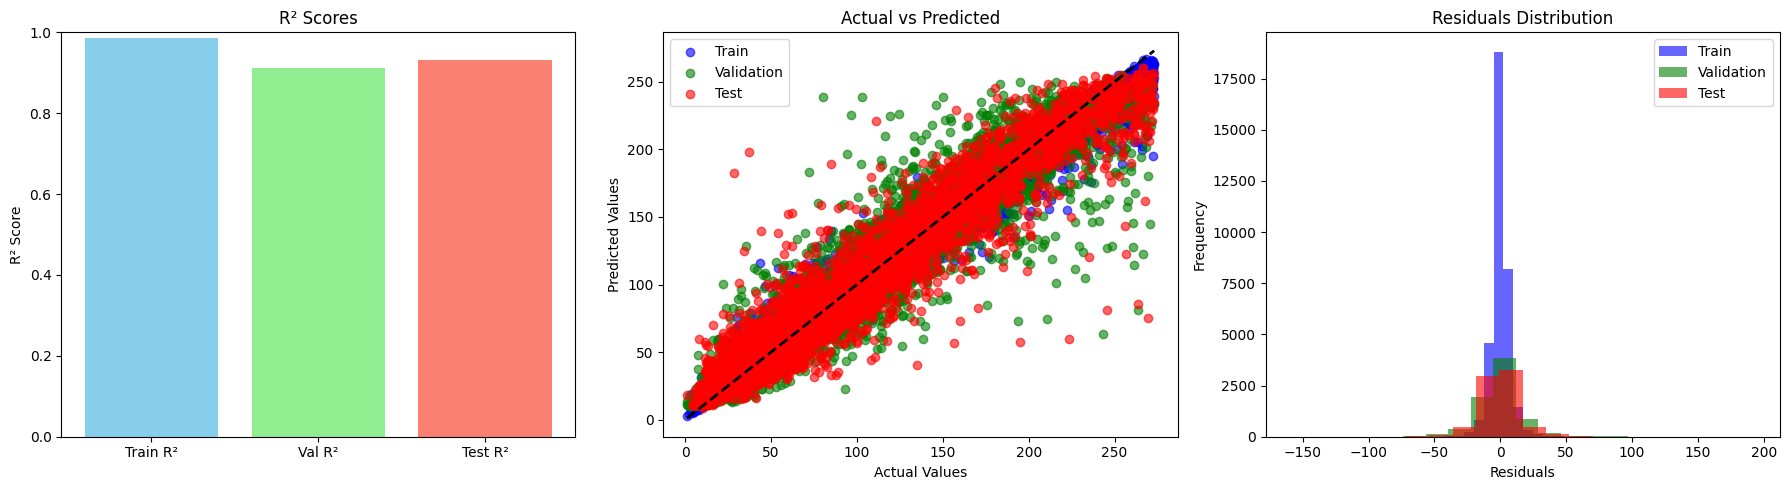

{'Train R²': 0.9867723539282459,
 'Validation R²': 0.9112637729763376,
 'Test R²': 0.9321038728899078,
 'Train MSE': 48.92499322579076,
 'Validation MSE': 336.6083003107462,
 'Test MSE': 253.70799039635622,
 'Train MAE': 4.7399061549237835,
 'Validation MAE': 11.707633884922352,
 'Test MAE': 10.373647364105857}

In [ ]:
# Random forest - NO LAG

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# --- Load Data ---
file_path = 'Book5 (1) (1).xlsx'
data = pd.read_excel(file_path)
data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')
data.set_index('Timestamp', inplace=True)

# --- Interpolate missing values ---
data.interpolate(method='linear', inplace=True)

# --- Outlier Removal (IQR) ---
Q1 = data['Avg_PM2.5'].quantile(0.25)
Q3 = data['Avg_PM2.5'].quantile(0.75)
IQR = Q3 - Q1
data = data[(data['Avg_PM2.5'] >= Q1 - 1.5 * IQR) & (data['Avg_PM2.5'] <= Q3 + 1.5 * IQR)]

# --- Rolling Features ---
data['PM2.5_Rolling_Mean7'] = data['Avg_PM2.5'].rolling(window=7).mean()
data['PM2.5_Rolling_Std7'] = data['Avg_PM2.5'].rolling(window=7).std()

# --- Fourier Features ---
def fourier_features(index, freq):
    t = np.arange(len(index))
    return np.column_stack(
        [np.sin(2 * np.pi * t / f) for f in freq] +
        [np.cos(2 * np.pi * t / f) for f in freq]
    )
freqs = [24, 168, 720]
fourier = fourier_features(data.index, freqs)
for i, f in enumerate(freqs):
    data[f'sin_{f}'] = fourier[:, i]
    data[f'cos_{f}'] = fourier[:, i + len(freqs)]

# --- Time Features ---
data['Hour'] = data.index.hour
data['Day'] = data.index.day
data['Month'] = data.index.month
data['Year'] = data.index.year

# --- Drop NaNs from rolling features ---
data.dropna(inplace=True)

# --- Define Features and Target ---
feature_columns = ['Hour', 'Day', 'Month', 'Year',
                   'Avg_AT (°C)', 'Avg_RH (%)', 'Avg_VWS (m/s)', "Avg_SR (W/mt2)",
                   'PM2.5_Rolling_Mean7', 'PM2.5_Rolling_Std7'] + \
                  [f'sin_{f}' for f in freqs] + [f'cos_{f}' for f in freqs]

X = data[feature_columns]
y = data['Avg_PM2.5']

# --- Train-Validation-Test Split ---
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False, random_state=42)

# --- Scaling ---
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# --- Evaluation Function ---
def evaluate_rf_model(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=1):
    rf_model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    rf_model.fit(X_train_scaled, y_train)
    y_train_pred = rf_model.predict(X_train_scaled)
    y_val_pred = rf_model.predict(X_val_scaled)
    y_test_pred = rf_model.predict(X_test_scaled)

    performance = {
        'Train R²': r2_score(y_train, y_train_pred),
        'Validation R²': r2_score(y_val, y_val_pred),
        'Test R²': r2_score(y_test, y_test_pred),
        'Train MSE': mean_squared_error(y_train, y_train_pred),
        'Validation MSE': mean_squared_error(y_val, y_val_pred),
        'Test MSE': mean_squared_error(y_test, y_test_pred),
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Validation MAE': mean_absolute_error(y_val, y_val_pred),
        'Test MAE': mean_absolute_error(y_test, y_test_pred)
    }

    print(f"Random Forest Model Performance:")
    for key, value in performance.items():
        print(f"{key}: {value:.4f}")

    # --- Visualization ---
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # R² Bar Plot
    axs[0].bar(['Train R²', 'Val R²', 'Test R²'],
               [performance['Train R²'], performance['Validation R²'], performance['Test R²']],
               color=['skyblue', 'lightgreen', 'salmon'])
    axs[0].set_title("R² Scores")
    axs[0].set_ylim(0, 1)
    axs[0].set_ylabel("R² Score")

    # Actual vs Predicted
    axs[1].scatter(y_train, y_train_pred, color='blue', alpha=0.6, label='Train')
    axs[1].scatter(y_val, y_val_pred, color='green', alpha=0.6, label='Validation')
    axs[1].scatter(y_test, y_test_pred, color='red', alpha=0.6, label='Test')
    axs[1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
    axs[1].set_title("Actual vs Predicted")
    axs[1].set_xlabel("Actual Values")
    axs[1].set_ylabel("Predicted Values")
    axs[1].legend()

    # Residuals
    train_residuals = y_train - y_train_pred
    val_residuals = y_val - y_val_pred
    test_residuals = y_test - y_test_pred
    axs[2].hist(train_residuals, bins=20, alpha=0.6, color='blue', label='Train')
    axs[2].hist(val_residuals, bins=20, alpha=0.6, color='green', label='Validation')
    axs[2].hist(test_residuals, bins=20, alpha=0.6, color='red', label='Test')
    axs[2].set_title("Residuals Distribution")
    axs[2].set_xlabel("Residuals")
    axs[2].set_ylabel("Frequency")
    axs[2].legend()

    plt.tight_layout()
    plt.show()

    return performance

# --- Run the Model ---
evaluate_rf_model(n_estimators=294, max_depth=20, min_samples_split=2, min_samples_leaf=1)


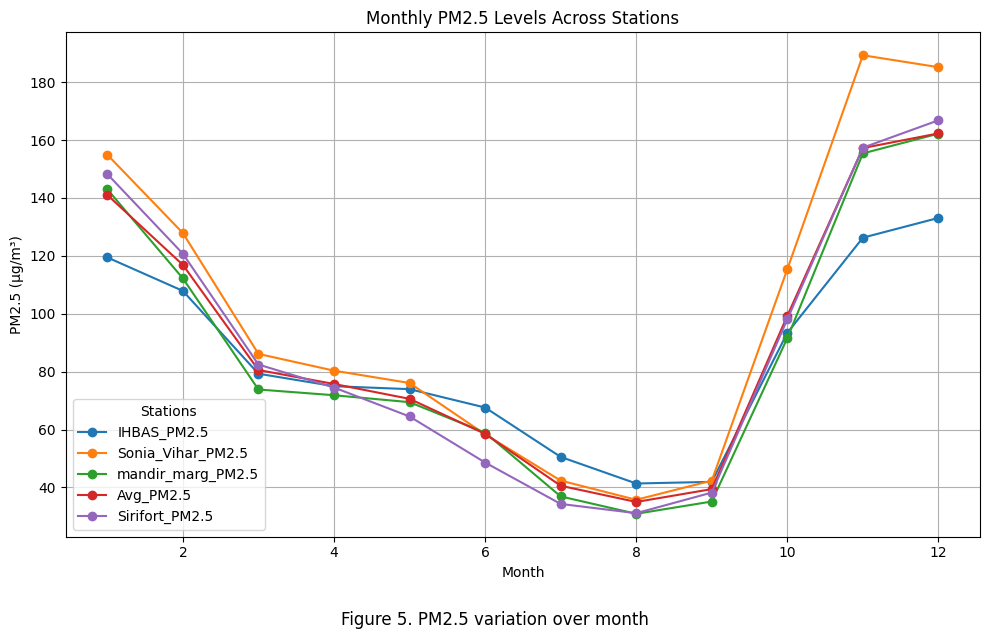

In [15]:
monthly_avg = data.groupby('Month')[['IHBAS_PM2.5', 'Sonia_Vihar_PM2.5', 'mandir_marg_PM2.5', 'Avg_PM2.5']].mean()

if 'Sirifort_PM2.5' in data.columns:
    monthly_avg['Sirifort_PM2.5'] = data.groupby('Month')['Sirifort_PM2.5'].mean()

# Plotting
plt.figure(figsize=(10, 6))
for column in monthly_avg.columns:
    plt.plot(monthly_avg.index, monthly_avg[column], marker='o', label=column)

plt.title('Monthly PM2.5 Levels Across Stations')
plt.xlabel('Month')
plt.ylabel('PM2.5 (µg/m³)')
plt.legend(title='Stations')
plt.grid(True)
plt.tight_layout()

# Caption like in the image
plt.figtext(0.5, -0.05, 'Figure 5. PM2.5 variation over month', ha='center', fontsize=12)

plt.show()


In [ ]:
#XGBoost - No Lag

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    mean_absolute_percentage_error, explained_variance_score,
    median_absolute_error
)
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import zscore

# Load the dataset
file_path = 'Book5 (1) (1).xlsx'
data = pd.read_excel(file_path)

# Convert 'Timestamp' to datetime and set it as the index
data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')
data.set_index('Timestamp', inplace=True)

# Interpolate missing values
data.interpolate(method='linear', inplace=True)

# Outlier removal using Z-score
cols_to_check = ['Avg_PM2.5', 'Avg_AT (°C)', 'Avg_RH (%)', 'Avg_VWS (m/s)', 'Avg_SR (W/mt2)']
z_scores = np.abs(zscore(data[cols_to_check]))
data = data[(z_scores < 3).all(axis=1)]

# Rolling features
data['PM2.5_Rolling_Mean7'] = data['Avg_PM2.5'].rolling(window=7).mean()
data['PM2.5_Rolling_Std7'] = data['Avg_PM2.5'].rolling(window=7).std()

# DateTime features
data['Hour'] = data.index.hour
data['Day'] = data.index.day
data['Month'] = data.index.month
data['Year'] = data.index.year

# Fourier features
def fourier_features(index, freq_list):
    t = np.arange(len(index))
    sin_cos = np.column_stack([
        np.sin(2 * np.pi * t / f) for f in freq_list
    ] + [
        np.cos(2 * np.pi * t / f) for f in freq_list
    ])
    return sin_cos

freqs = [24, 168, 720]  # daily, weekly, monthly cycles
fourier_feats = fourier_features(data.index, freqs)

# Add Fourier features to DataFrame
for i, f in enumerate(freqs):
    data[f'sin_{f}'] = fourier_feats[:, i]
    data[f'cos_{f}'] = fourier_feats[:, i + len(freqs)]

# Drop NaNs from rolling features
data.dropna(inplace=True)

# Define feature columns and target (removed lag features)
fourier_cols = [f'sin_{f}' for f in freqs] + [f'cos_{f}' for f in freqs]

X = data[['Hour', 'Day', 'Month', 'Year', 'Avg_AT (°C)', 'Avg_RH (%)',
          'Avg_VWS (m/s)', 'Avg_SR (W/mt2)', 'PM2.5_Rolling_Mean7', 'PM2.5_Rolling_Std7'] + fourier_cols]

y = data['Avg_PM2.5']

# Split into train/val/test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=42)
y_val, y_test = train_test_split(y_temp, test_size=0.5, random_state=42)

# Normalize features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Define and train XGB model
xgb_model = XGBRegressor(
    n_estimators=294,
    max_depth=20,
    learning_rate=0.0255,
    min_child_weight=2,
    subsample=0.743,
    random_state=42
)

xgb_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred = xgb_model.predict(X_train_scaled)
y_val_pred = xgb_model.predict(X_val_scaled)
y_test_pred = xgb_model.predict(X_test_scaled)

# Evaluation metrics
performance = {
    'Train R²': r2_score(y_train, y_train_pred),
    'Validation R²': r2_score(y_val, y_val_pred),
    'Test R²': r2_score(y_test, y_test_pred),
    'Train MSE': mean_squared_error(y_train, y_train_pred),
    'Validation MSE': mean_squared_error(y_val, y_val_pred),
    'Test MSE': mean_squared_error(y_test, y_test_pred),
    'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
    'Validation RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred)),
    'Test RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
    'Train MAE': mean_absolute_error(y_train, y_train_pred),
    'Validation MAE': mean_absolute_error(y_val, y_val_pred),
    'Test MAE': mean_absolute_error(y_test, y_test_pred),
}

# Print metrics
print("\nModel Performance:")
for metric, value in performance.items():
    print(f"{metric}: {value:.4f}")



Model Performance:
Train R²: 0.9996
Validation R²: 0.9297
Test R²: 0.9300
Train MSE: 2.1732
Validation MSE: 369.2032
Test MSE: 347.6541
Train RMSE: 1.4742
Validation RMSE: 19.2147
Test RMSE: 18.6455
Train MAE: 0.9596
Validation MAE: 11.1434
Test MAE: 11.1107


In [ ]:
#CNN+Bi-lstm NO lag

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Bidirectional

# --- Load and preprocess data ---
file_path = 'Book5 (1) (1).xlsx'
data = pd.read_excel(file_path)

data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')
data.set_index('Timestamp', inplace=True)
data.interpolate(method='linear', inplace=True)

# Rolling statistical features (no lags)
data['PM2.5_Rolling_Mean7'] = data['Avg_PM2.5'].rolling(window=7).mean()
data['PM2.5_Rolling_Std7'] = data['Avg_PM2.5'].rolling(window=7).std()
data.dropna(inplace=True)

# Datetime features
data['Hour'] = data.index.hour
data['Day'] = data.index.day
data['Month'] = data.index.month
data['Year'] = data.index.year

# Features & Target (no lag features)
features = ['Hour', 'Day', 'Month', 'Year', 'Avg_AT (°C)', 'Avg_RH (%)',
            'Avg_VWS (m/s)', 'Avg_SR (W/mt2)', 'PM2.5_Rolling_Mean7', 'PM2.5_Rolling_Std7']
X = data[features]
y = data['Avg_PM2.5']

# Train-validation-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

# Reshape for CNN-LSTM: (samples, timesteps, features)
X_train_cnn = X_train_norm.reshape((X_train_norm.shape[0], 1, X_train_norm.shape[1]))
X_val_cnn = X_val_norm.reshape((X_val_norm.shape[0], 1, X_val_norm.shape[1]))
X_test_cnn = X_test_norm.reshape((X_test_norm.shape[0], 1, X_test_norm.shape[1]))

# --- Build CNN + BiLSTM Model ---
model = Sequential([
    Conv1D(64, kernel_size=1, activation='relu', input_shape=(1, X_train_cnn.shape[2])),
    BatchNormalization(),
    Conv1D(128, kernel_size=1, activation='relu'),
    BatchNormalization(),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

# --- Train the Model ---
model.fit(X_train_cnn, y_train, validation_data=(X_val_cnn, y_val),
          epochs=100, batch_size=32, verbose=1, callbacks=[early_stop])

# Predictions
y_train_pred = model.predict(X_train_cnn).flatten()
y_val_pred = model.predict(X_val_cnn).flatten()
y_test_pred = model.predict(X_test_cnn).flatten()

# --- Performance Metrics ---
performance = {
    'Train R²': r2_score(y_train, y_train_pred),
    'Validation R²': r2_score(y_val, y_val_pred),
    'Test R²': r2_score(y_test, y_test_pred),
    'Train MSE': mean_squared_error(y_train, y_train_pred),
    'Validation MSE': mean_squared_error(y_val, y_val_pred),
    'Test MSE': mean_squared_error(y_test, y_test_pred),
    'Train MAE': mean_absolute_error(y_train, y_train_pred),
    'Validation MAE': mean_absolute_error(y_val, y_val_pred),
    'Test MAE': mean_absolute_error(y_test, y_test_pred),
}
print("\nPerformance:")
for metric, val in performance.items():
    print(f"{metric}: {val:.4f}")


Epoch 1/100


c:\Users\yuvik\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


972/972 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 5783.2300 - val_loss: 851.5033
Epoch 2/100
972/972 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 1225.1296 - val_loss: 774.4519
Epoch 3/100
972/972 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 1092.7234 - val_loss: 654.7051
Epoch 4/100
972/972 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 979.3353 - val_loss: 646.6989
Epoch 5/100
972/972 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 956.4891 - val_loss: 636.1475
Epoch 6/100
972/972 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 834.2906 - val_loss: 670.9211
Epoch 7/100
972/972 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 798.7983 - val_loss: 666.3729
Epoch 8/100
972/972 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 758.3474 - val_loss: 631.0779
Epoch 9/100
972/972 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 757.7540 - val_loss: 587.6337
Epoch 10/100
972/972 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 747.3708 - val_loss: 699.7494
Epoch 11/100
972/972 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 722.2793 - val_loss: 698.9820
Epoc

Random Forest Model Performance:
Train R²: 0.9932
Validation R²: 0.9621
Test R²: 0.9692
Train MSE: 25.1861
Validation MSE: 143.8281
Test MSE: 115.2677
Train MAE: 3.4643
Validation MAE: 8.1285
Test MAE: 6.9358


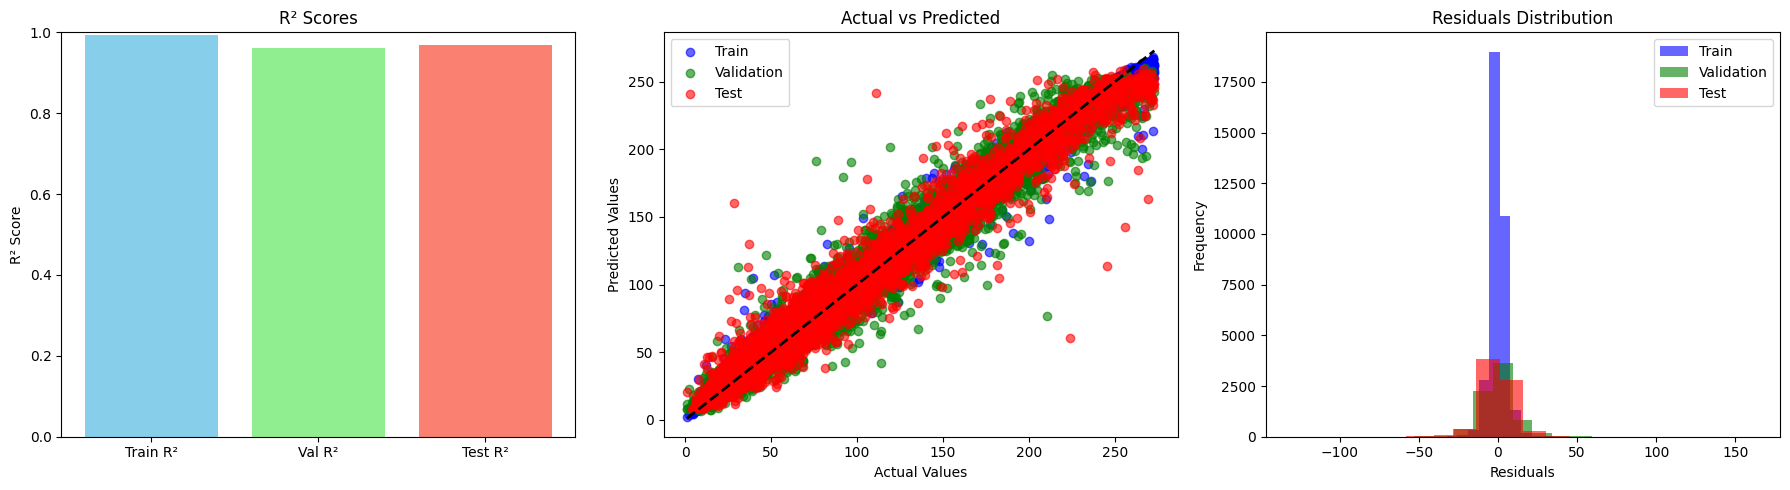

{'Train R²': 0.9931905503021142,
 'Validation R²': 0.9620842173762499,
 'Test R²': 0.9691526049866854,
 'Train MSE': 25.186059449521377,
 'Validation MSE': 143.82814744342133,
 'Test MSE': 115.26770275277342,
 'Train MAE': 3.4642723655030783,
 'Validation MAE': 8.128547110436687,
 'Test MAE': 6.935751936255142}

In [ ]:
# With Lag - Random Forest

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# --- Load Data ---
file_path = 'Book5 (1) (1).xlsx'
data = pd.read_excel(file_path)
data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')
data.set_index('Timestamp', inplace=True)

# --- Interpolate missing values ---
data.interpolate(method='linear', inplace=True)

# --- Outlier Removal (IQR) ---
Q1 = data['Avg_PM2.5'].quantile(0.25)
Q3 = data['Avg_PM2.5'].quantile(0.75)
IQR = Q3 - Q1
data = data[(data['Avg_PM2.5'] >= Q1 - 1.5 * IQR) & (data['Avg_PM2.5'] <= Q3 + 1.5 * IQR)]

"""While lag features capture specific past values, rolling metrics summarize recent trends and fluctuations.
 model understand whether the PM2.5 level is part of a stable period or a rapidly changing trend."""

# --- Lag and Rolling Features ---
data['PM2.5_Lag1'] = data['Avg_PM2.5'].shift(1)
data['PM2.5_Lag2'] = data['Avg_PM2.5'].shift(2)
data['PM2.5_Rolling_Mean7'] = data['Avg_PM2.5'].rolling(window=7).mean() # 7-day moving average
data['PM2.5_Rolling_Std7'] = data['Avg_PM2.5'].rolling(window=7).std()



"""Because pollution has seasonal and periodic patterns:
Daily traffic patterns.
Weekly human activity patterns.
Monthly/seasonal weather shifts."""


# --- Fourier Features ---
def fourier_features(index, freq):
    t = np.arange(len(index))
    return np.column_stack(
        [np.sin(2 * np.pi * t / f) for f in freq] + #cyclic patters
        [np.cos(2 * np.pi * t / f) for f in freq]
    )
freqs = [24, 168, 720] # daily, weekly and monthly cycles assumed
fourier = fourier_features(data.index, freqs)
for i, f in enumerate(freqs):
    data[f'sin_{f}'] = fourier[:, i]
    data[f'cos_{f}'] = fourier[:, i + len(freqs)]

# --- Time Features ---
data['Hour'] = data.index.hour
data['Day'] = data.index.day
data['Month'] = data.index.month
data['Year'] = data.index.year

# --- Drop NaNs from lag/rolling ---
data.dropna(inplace=True)

# --- Define Features and Target ---
feature_columns = ['Hour', 'Day', 'Month', 'Year',
                   'Avg_AT (°C)', 'Avg_RH (%)', 'Avg_VWS (m/s)', "Avg_SR (W/mt2)",
                   'PM2.5_Lag1', 'PM2.5_Lag2',
                   'PM2.5_Rolling_Mean7', 'PM2.5_Rolling_Std7'] + \
                  [f'sin_{f}' for f in freqs] + [f'cos_{f}' for f in freqs]

X = data[feature_columns]
y = data['Avg_PM2.5']

# --- Train-Validation-Test Split ---
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False, random_state=42)

# --- Scaling ---
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# --- Evaluation Function ---
def evaluate_rf_model(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=1):
    rf_model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    rf_model.fit(X_train_scaled, y_train)
    y_train_pred = rf_model.predict(X_train_scaled)
    y_val_pred = rf_model.predict(X_val_scaled)
    y_test_pred = rf_model.predict(X_test_scaled)

    performance = {
        'Train R²': r2_score(y_train, y_train_pred),
        'Validation R²': r2_score(y_val, y_val_pred),
        'Test R²': r2_score(y_test, y_test_pred),
        'Train MSE': mean_squared_error(y_train, y_train_pred),
        'Validation MSE': mean_squared_error(y_val, y_val_pred),
        'Test MSE': mean_squared_error(y_test, y_test_pred),
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Validation MAE': mean_absolute_error(y_val, y_val_pred),
        'Test MAE': mean_absolute_error(y_test, y_test_pred)
    }

    print(f"Random Forest Model Performance:")
    for key, value in performance.items():
        print(f"{key}: {value:.4f}")

    # --- Visualization ---
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # R² Bar Plot
    axs[0].bar(['Train R²', 'Val R²', 'Test R²'],
               [performance['Train R²'], performance['Validation R²'], performance['Test R²']],
               color=['skyblue', 'lightgreen', 'salmon'])
    axs[0].set_title("R² Scores")
    axs[0].set_ylim(0, 1)
    axs[0].set_ylabel("R² Score")

    # Actual vs Predicted
    axs[1].scatter(y_train, y_train_pred, color='blue', alpha=0.6, label='Train')
    axs[1].scatter(y_val, y_val_pred, color='green', alpha=0.6, label='Validation')
    axs[1].scatter(y_test, y_test_pred, color='red', alpha=0.6, label='Test')
    axs[1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
    axs[1].set_title("Actual vs Predicted")
    axs[1].set_xlabel("Actual Values")
    axs[1].set_ylabel("Predicted Values")
    axs[1].legend()


    # Residuals
    train_residuals = y_train - y_train_pred
    val_residuals = y_val - y_val_pred
    test_residuals = y_test - y_test_pred
    axs[2].hist(train_residuals, bins=20, alpha=0.6, color='blue', label='Train')
    axs[2].hist(val_residuals, bins=20, alpha=0.6, color='green', label='Validation')
    axs[2].hist(test_residuals, bins=20, alpha=0.6, color='red', label='Test')
    axs[2].set_title("Residuals Distribution")
    axs[2].set_xlabel("Residuals")
    axs[2].set_ylabel("Frequency")
    axs[2].legend()
    
    plt.tight_layout()
    plt.show()

    return performance

# --- Run the Model ---
evaluate_rf_model(n_estimators=294, max_depth=20, min_samples_split=2, min_samples_leaf=1)


Random Forest Model Performance:
Train R²: 0.9932
Validation R²: 0.9621
Test R²: 0.9691
Train MSE: 25.0893
Validation MSE: 143.6690
Test MSE: 115.3705
Train MAE: 3.4582
Validation MAE: 8.1257
Test MAE: 6.9288


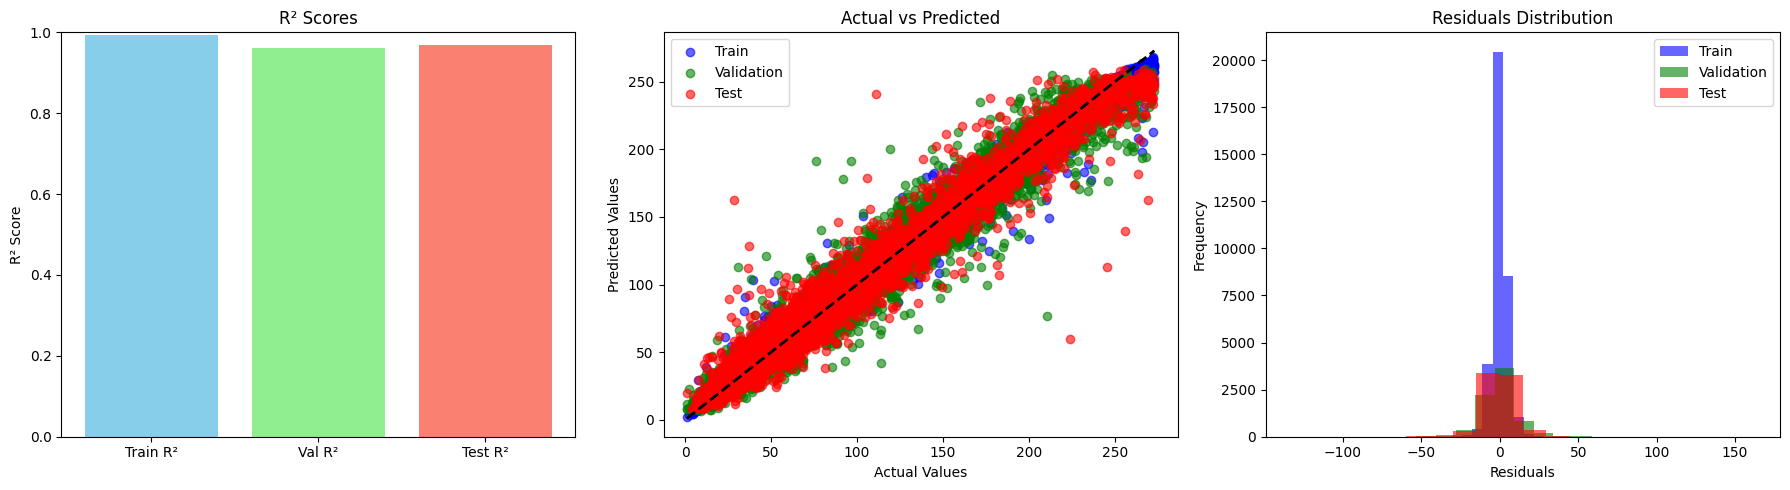

{'Train R²': 0.9932166993042241,
 'Validation R²': 0.9621261723925376,
 'Test R²': 0.969125092029386,
 'Train MSE': 25.089342335671653,
 'Validation MSE': 143.66899703556908,
 'Test MSE': 115.37051063598275,
 'Train MAE': 3.458177832865841,
 'Validation MAE': 8.125712891131792,
 'Test MAE': 6.928792329038848}

In [2]:
# Example usage with specified parameters
evaluate_rf_model(n_estimators=395, max_depth=20, min_samples_split=2, min_samples_leaf=1)

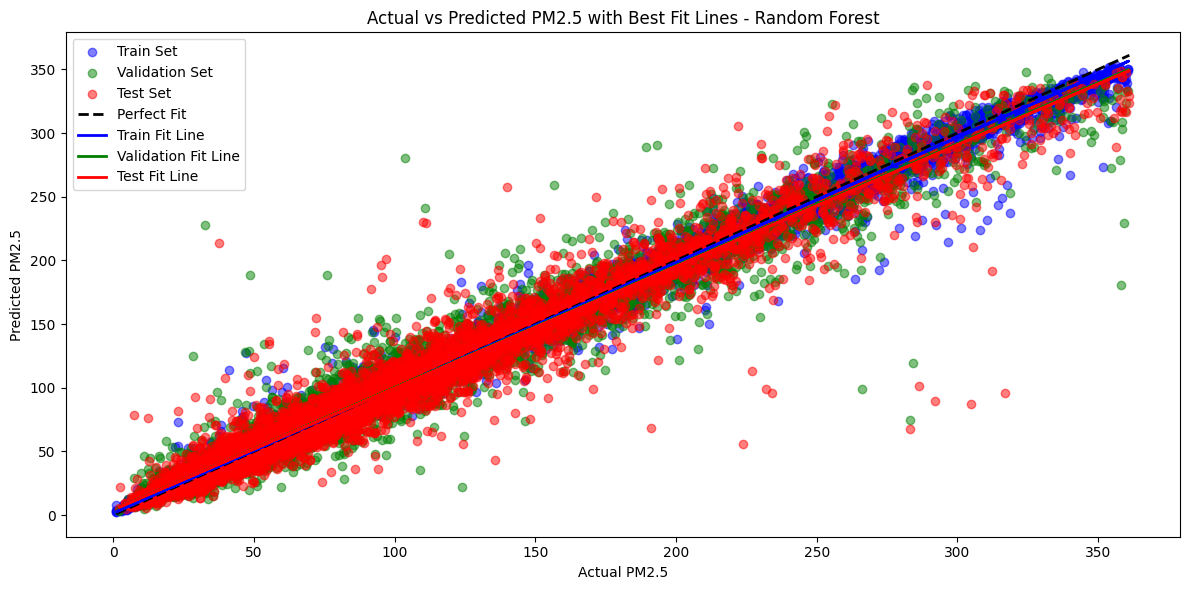

In [3]:
# Actual vs Predicted Fitted lines - Random Forest

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore
import matplotlib.pyplot as plt

# 1. Load and preprocess data

file_path = 'Book5 (1) (1).xlsx'
data = pd.read_excel(file_path)

# Convert 'Timestamp' to datetime and set as index
data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')
data.set_index('Timestamp', inplace=True)

# Interpolate missing values linearly
data.interpolate(method='linear', inplace=True)

# 2. Remove outliers using Z-scores

z_scores = np.abs(zscore(data[['Avg_PM2.5', 'Avg_AT (°C)', 'Avg_RH (%)', 'Avg_VWS (m/s)', "Avg_SR (W/mt2)"]]))
data = data[(z_scores < 3).all(axis=1)]

# 3. Create lagged & rolling statistical features

data['PM2.5_Lag1'] = data['Avg_PM2.5'].shift(1)
data['PM2.5_Lag2'] = data['Avg_PM2.5'].shift(2)
data['PM2.5_Rolling_Mean7'] = data['Avg_PM2.5'].rolling(window=7).mean()
data['PM2.5_Rolling_Std7'] = data['Avg_PM2.5'].rolling(window=7).std()

# Drop rows with NaNs
data.dropna(inplace=True)

# 4. Extract datetime and Fourier features

data['Hour'] = data.index.hour
data['Day'] = data.index.day
data['Month'] = data.index.month
data['Year'] = data.index.year

# Fourier feature generator
def fourier_features(index, freq):
    t = np.arange(len(index))
    return np.column_stack([np.sin(2 * np.pi * t / f) for f in freq] +
                           [np.cos(2 * np.pi * t / f) for f in freq])

freqs = [24, 168, 720]  # Daily, weekly, and monthly cycles (hourly data assumed)
fourier = fourier_features(data.index, freqs)

# Add Fourier features to DataFrame
for i, f in enumerate(freqs):
    data[f'sin_{f}'] = fourier[:, i]
    data[f'cos_{f}'] = fourier[:, i + len(freqs)]

# 5. Define features and target

X = data[['Hour', 'Day', 'Month', 'Year', 'Avg_AT (°C)', 'Avg_RH (%)', 'Avg_VWS (m/s)', "Avg_SR (W/mt2)",
          'PM2.5_Lag1', 'PM2.5_Lag2', 'PM2.5_Rolling_Mean7', 'PM2.5_Rolling_Std7'] +
         [f'sin_{f}' for f in freqs] + [f'cos_{f}' for f in freqs]]

y = data['Avg_PM2.5']

# 6. Train-test-validation split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize features
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_val_normalized = scaler.transform(X_val)
X_test_normalized = scaler.transform(X_test)

# 7. Train Random Forest Regressor

rf_model = RandomForestRegressor(
    n_estimators=294, max_depth=20, min_samples_split=2,
    min_samples_leaf=1, random_state=42
)
rf_model.fit(X_train_normalized, y_train)

# 8. Predictions and evaluation

y_train_pred = rf_model.predict(X_train_normalized)
y_val_pred = rf_model.predict(X_val_normalized)
y_test_pred = rf_model.predict(X_test_normalized)

train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)
test_r2 = r2_score(y_test, y_test_pred)

# 9. Visualization - Actual vs Predicted
fig, ax = plt.subplots(figsize=(12, 6))

# Scatter plots
ax.scatter(y_train, y_train_pred, color='blue', alpha=0.5, label='Train Set')
ax.scatter(y_val, y_val_pred, color='green', alpha=0.5, label='Validation Set')
ax.scatter(y_test, y_test_pred, color='red', alpha=0.5, label='Test Set')

# Diagonal reference line
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, label="Perfect Fit")

# Best-fit lines
train_line = np.poly1d(np.polyfit(y_train, y_train_pred, 1))(y_train)
val_line = np.poly1d(np.polyfit(y_val, y_val_pred, 1))(y_val)
test_line = np.poly1d(np.polyfit(y_test, y_test_pred, 1))(y_test)

ax.plot(y_train, train_line, color='blue', lw=2, linestyle='-', label='Train Fit Line')
ax.plot(y_val, val_line, color='green', lw=2, linestyle='-', label='Validation Fit Line')
ax.plot(y_test, test_line, color='red', lw=2, linestyle='-', label='Test Fit Line')

# Titles and labels
ax.set_title("Actual vs Predicted PM2.5 with Best Fit Lines - Random Forest")
ax.set_xlabel("Actual PM2.5")
ax.set_ylabel("Predicted PM2.5")
ax.legend()

plt.tight_layout()
plt.show()

Baseline Model Performance with All Features:
{'Train R²': 0.9936903460118557, 'Validation R²': 0.9587817601974634, 'Test R²': 0.9551073855275412}


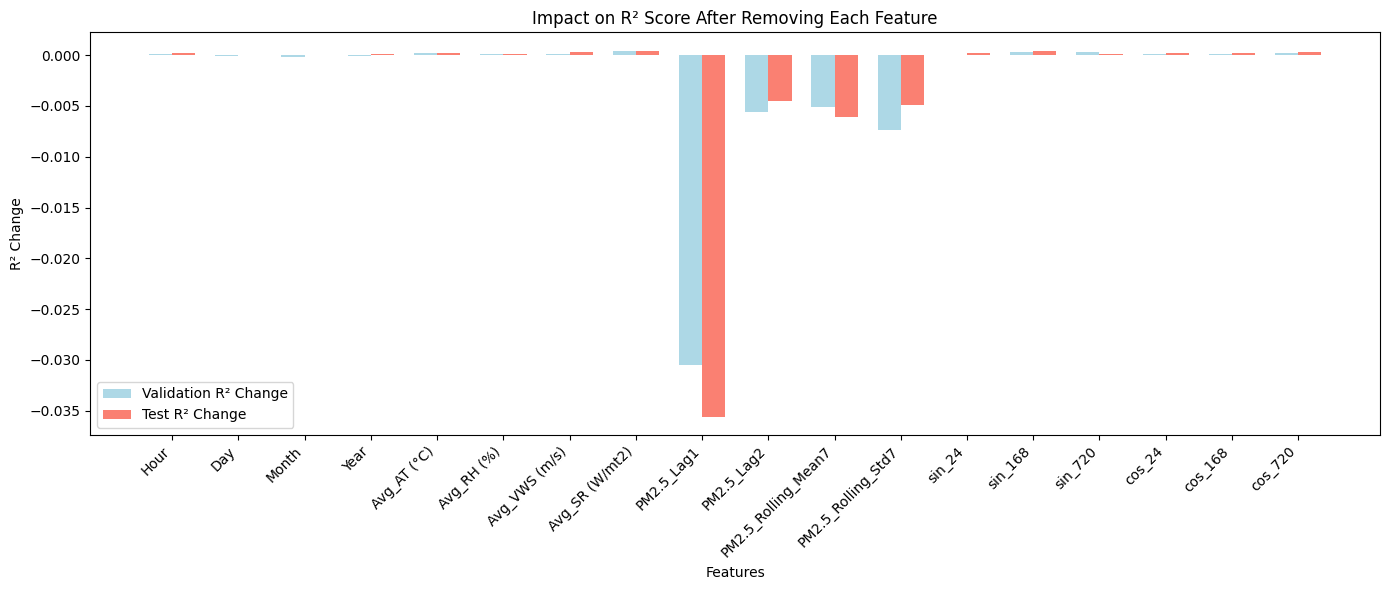

In [1]:
#R2 - Feature wise

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore
import matplotlib.pyplot as plt


file_path = 'Book5 (1) (1).xlsx'
data = pd.read_excel(file_path)

# Convert 'Timestamp' to datetime and set as index
data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')
data.set_index('Timestamp', inplace=True)

# Interpolate missing values linearly
data.interpolate(method='linear', inplace=True)

z_scores = np.abs(zscore(data[['Avg_PM2.5', 'Avg_AT (°C)', 'Avg_RH (%)', 'Avg_VWS (m/s)', "Avg_SR (W/mt2)"]]))
data = data[(z_scores < 3).all(axis=1)]

# 3. Create lagged, rolling, datetime features

data['PM2.5_Lag1'] = data['Avg_PM2.5'].shift(1)
data['PM2.5_Lag2'] = data['Avg_PM2.5'].shift(2)
data['PM2.5_Rolling_Mean7'] = data['Avg_PM2.5'].rolling(window=7).mean()
data['PM2.5_Rolling_Std7'] = data['Avg_PM2.5'].rolling(window=7).std()

data['Hour'] = data.index.hour
data['Day'] = data.index.day
data['Month'] = data.index.month
data['Year'] = data.index.year


def fourier_features(index, freq):
    t = np.arange(len(index))
    return np.column_stack([np.sin(2 * np.pi * t / f) for f in freq] +
                           [np.cos(2 * np.pi * t / f) for f in freq])

freqs = [24, 168, 720]  # Daily, weekly, monthly
fourier = fourier_features(data.index, freqs)

for i, f in enumerate(freqs):
    data[f'sin_{f}'] = fourier[:, i]
    data[f'cos_{f}'] = fourier[:, i + len(freqs)]

# Drop rows with NaNs from rolling/lag
data.dropna(inplace=True)

# Define features and target

fourier_cols = [f'sin_{f}' for f in freqs] + [f'cos_{f}' for f in freqs]

X = data[['Hour', 'Day', 'Month', 'Year', 'Avg_AT (°C)', 'Avg_RH (%)',
          'Avg_VWS (m/s)', "Avg_SR (W/mt2)", 'PM2.5_Lag1', 'PM2.5_Lag2',
          'PM2.5_Rolling_Mean7', 'PM2.5_Rolling_Std7'] + fourier_cols]

y = data['Avg_PM2.5']


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_val_normalized = scaler.transform(X_val)
X_test_normalized = scaler.transform(X_test)

# 7. Train and evaluate function

def train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test):
    rf_model = RandomForestRegressor(n_estimators=294, max_depth=20, min_samples_split=2, min_samples_leaf=1, random_state=42)
    rf_model.fit(X_train, y_train)

    y_train_pred = rf_model.predict(X_train)
    y_val_pred = rf_model.predict(X_val)
    y_test_pred = rf_model.predict(X_test)

    performance = {
        'Train R²': r2_score(y_train, y_train_pred),
        'Validation R²': r2_score(y_val, y_val_pred),
        'Test R²': r2_score(y_test, y_test_pred)
    }
    return performance

# 8. Baseline Model Performance

print("Baseline Model Performance with All Features:")
baseline_performance = train_and_evaluate(X_train_normalized, y_train, X_val_normalized, y_val, X_test_normalized, y_test)
print(baseline_performance)

# 9. Feature Importance Analysis (Leave-One-Out)

validation_r2_changes = {}
test_r2_changes = {}

for feature in X.columns:
    X_train_dropped = X_train.drop(columns=[feature])
    X_val_dropped = X_val.drop(columns=[feature])
    X_test_dropped = X_test.drop(columns=[feature])

    # Normalize after dropping
    scaler = MinMaxScaler()
    X_train_dropped_normalized = scaler.fit_transform(X_train_dropped)
    X_val_dropped_normalized = scaler.transform(X_val_dropped)
    X_test_dropped_normalized = scaler.transform(X_test_dropped)

    performance = train_and_evaluate(X_train_dropped_normalized, y_train, X_val_dropped_normalized, y_val, X_test_dropped_normalized, y_test)

    validation_r2_changes[feature] = performance['Validation R²'] - baseline_performance['Validation R²']
    test_r2_changes[feature] = performance['Test R²'] - baseline_performance['Test R²']

# 10. Plotting Feature Impact on R²

features = list(validation_r2_changes.keys())
validation_changes = list(validation_r2_changes.values())
test_changes = list(test_r2_changes.values())

fig, ax = plt.subplots(figsize=(14, 6))
bar_width = 0.35
index = np.arange(len(features))

val_bars = ax.bar(index, validation_changes, bar_width, label='Validation R² Change', color='lightblue')
test_bars = ax.bar(index + bar_width, test_changes, bar_width, label='Test R² Change', color='salmon')

ax.set_xlabel('Features')
ax.set_ylabel('R² Change')
ax.set_title('Impact on R² Score After Removing Each Feature')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(features, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    mean_absolute_percentage_error, explained_variance_score,
    median_absolute_error
)
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import zscore

# Load the dataset
file_path = 'Book5 (1) (1).xlsx'
data = pd.read_excel(file_path)

# Convert 'Timestamp' to datetime and set it as the index
data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')
data.set_index('Timestamp', inplace=True)

# Interpolate missing values
data.interpolate(method='linear', inplace=True)

# Outlier removal using Z-score
cols_to_check = ['Avg_PM2.5', 'Avg_AT (°C)', 'Avg_RH (%)', 'Avg_VWS (m/s)', 'Avg_SR (W/mt2)']
z_scores = np.abs(zscore(data[cols_to_check]))
data = data[(z_scores < 3).all(axis=1)]

# Lag and rolling features
data['PM2.5_Lag1'] = data['Avg_PM2.5'].shift(1)
data['PM2.5_Lag2'] = data['Avg_PM2.5'].shift(2)
data['PM2.5_Rolling_Mean7'] = data['Avg_PM2.5'].rolling(window=7).mean()
data['PM2.5_Rolling_Std7'] = data['Avg_PM2.5'].rolling(window=7).std()

# DateTime features
data['Hour'] = data.index.hour
data['Day'] = data.index.day
data['Month'] = data.index.month
data['Year'] = data.index.year

# Fourier features
def fourier_features(index, freq_list):
    t = np.arange(len(index))
    sin_cos = np.column_stack([
        np.sin(2 * np.pi * t / f) for f in freq_list
    ] + [
        np.cos(2 * np.pi * t / f) for f in freq_list
    ])
    return sin_cos

freqs = [24, 168, 720]  # daily, weekly, monthly cycles
fourier_feats = fourier_features(data.index, freqs)

# Add Fourier features to DataFrame
for i, f in enumerate(freqs):
    data[f'sin_{f}'] = fourier_feats[:, i]
    data[f'cos_{f}'] = fourier_feats[:, i + len(freqs)]

# Drop NaNs from lag and rolling features
data.dropna(inplace=True)

# Define feature columns and target
fourier_cols = [f'sin_{f}' for f in freqs] + [f'cos_{f}' for f in freqs]

X = data[['Hour', 'Day', 'Month', 'Year', 'Avg_AT (°C)', 'Avg_RH (%)',
          'Avg_VWS (m/s)', 'Avg_SR (W/mt2)', 'PM2.5_Lag1', 'PM2.5_Lag2',
          'PM2.5_Rolling_Mean7', 'PM2.5_Rolling_Std7'] + fourier_cols]

y = data['Avg_PM2.5']

# Split into train/val/test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=42)
y_val, y_test = train_test_split(y_temp, test_size=0.5, random_state=42)

# Normalize features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Define and train XGB model
xgb_model = XGBRegressor(
    n_estimators=294,
    max_depth=20,
    learning_rate=0.0255,
    min_child_weight=2,
    subsample=0.743,
    random_state=42
)

xgb_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred = xgb_model.predict(X_train_scaled)
y_val_pred = xgb_model.predict(X_val_scaled)
y_test_pred = xgb_model.predict(X_test_scaled)

# Evaluation metrics
performance = {
    'Train R²': r2_score(y_train, y_train_pred),
    'Validation R²': r2_score(y_val, y_val_pred),
    'Test R²': r2_score(y_test, y_test_pred),
    'Train MSE': mean_squared_error(y_train, y_train_pred),
    'Validation MSE': mean_squared_error(y_val, y_val_pred),
    'Test MSE': mean_squared_error(y_test, y_test_pred),
    'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
    'Validation RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred)),
    'Test RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
    'Train MAE': mean_absolute_error(y_train, y_train_pred),
    'Validation MAE': mean_absolute_error(y_val, y_val_pred),
    'Test MAE': mean_absolute_error(y_test, y_test_pred),
}

# Print metrics
print("\nModel Performance:")
for metric, value in performance.items():
    print(f"{metric}: {value:.4f}")



Model Performance:
Train R²: 0.9996
Validation R²: 0.9623
Test R²: 0.9624
Train MSE: 2.0887
Validation MSE: 198.0682
Test MSE: 186.6555
Train RMSE: 1.4452
Validation RMSE: 14.0737
Test RMSE: 13.6622
Train MAE: 0.8932
Validation MAE: 8.3345
Test MAE: 8.2217


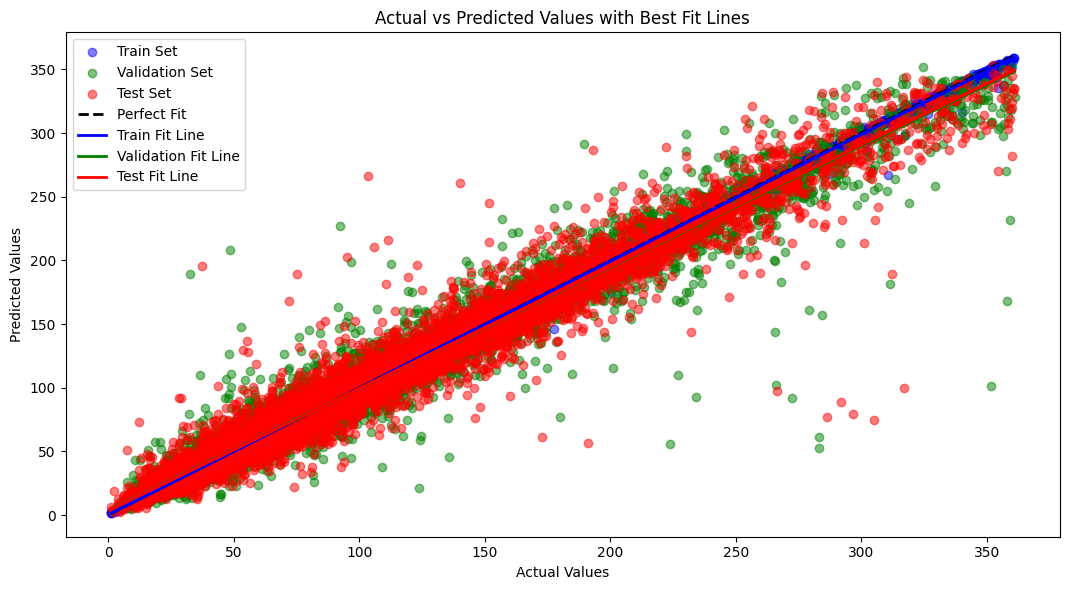

In [7]:
# Combined Scatter Plot of Actual vs Predicted values for Train, Validation, and Test sets
fig, ax = plt.subplots(figsize=(12, 6))

# Scatter plots for each set
ax.scatter(y_train, y_train_pred, color='blue', alpha=0.5, label='Train Set')
ax.scatter(y_val, y_val_pred, color='green', alpha=0.5, label='Validation Set')
ax.scatter(y_test, y_test_pred, color='red', alpha=0.5, label='Test Set')

# Diagonal line for reference (perfect predictions)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, label="Perfect Fit")

# Best-fit lines for Train, Validation, and Test sets
train_coeffs = np.polyfit(y_train, y_train_pred, 1)
val_coeffs = np.polyfit(y_val, y_val_pred, 1)
test_coeffs = np.polyfit(y_test, y_test_pred, 1)

# Generate lines using the best-fit coefficients
y_train_line = np.poly1d(train_coeffs)(y_train)
y_val_line = np.poly1d(val_coeffs)(y_val)
y_test_line = np.poly1d(test_coeffs)(y_test)

# Plot the best-fit lines
ax.plot(y_train, y_train_line, color='blue', lw=2, linestyle='-', label='Train Fit Line')
ax.plot(y_val, y_val_line, color='green', lw=2, linestyle='-', label='Validation Fit Line')
ax.plot(y_test, y_test_line, color='red', lw=2, linestyle='-', label='Test Fit Line')



# Titles and labels
ax.set_title("Actual vs Predicted Values with Best Fit Lines")
ax.set_xlabel("Actual Values")
ax.set_ylabel("Predicted Values")
ax.legend()

plt.tight_layout(rect=[0, 0, 0.9, 1])  

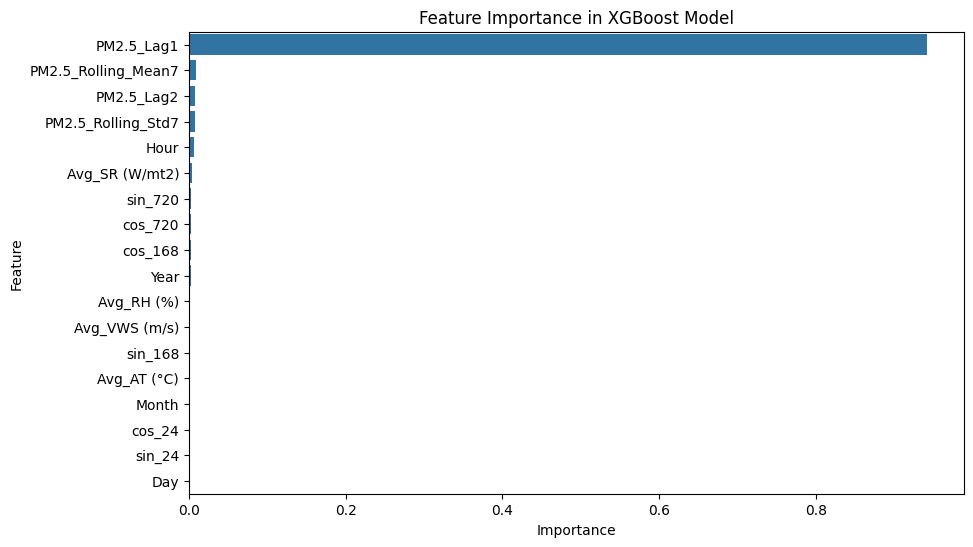

In [8]:
# Feature Importance for XGBoost
feature_importance_xgb = xgb_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance_xgb}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Feature Importance in XGBoost Model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


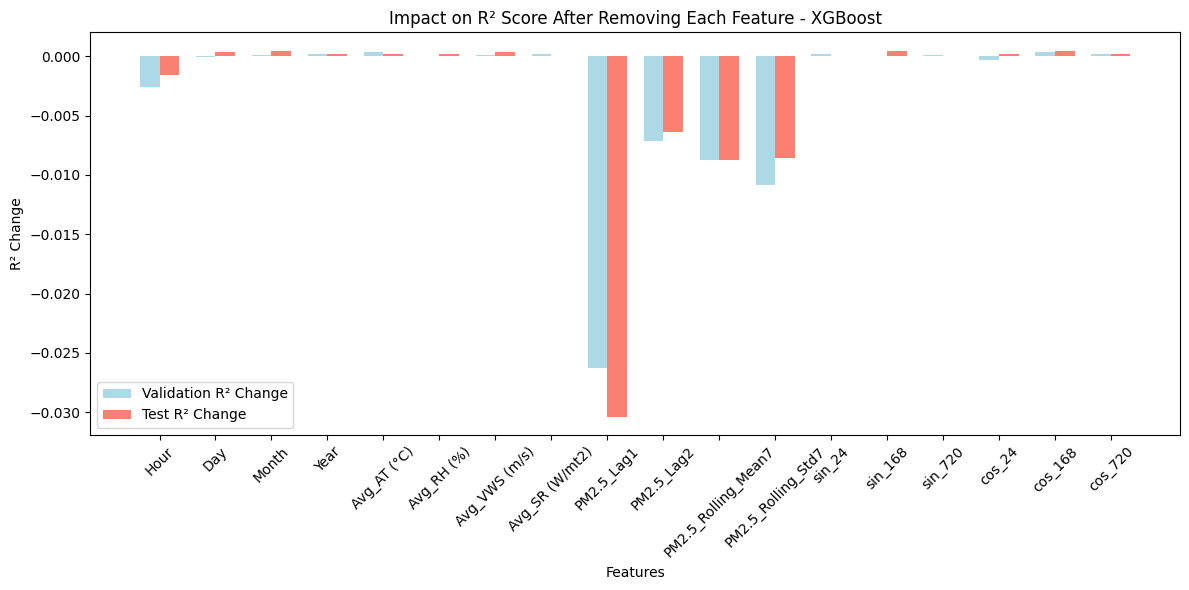

In [10]:
# Store the changes in performance after feature removal for XGBoost
validation_r2_changes_xgb = {}
test_r2_changes_xgb = {}

# Evaluate model performance after removing each feature one-by-one for XGBoost
for feature in X.columns:
    X_train_dropped = X_train.drop(columns=[feature])
    X_val_dropped = X_val.drop(columns=[feature])
    X_test_dropped = X_test.drop(columns=[feature])

    # Normalize features after dropping
    X_train_dropped_normalized = scaler.fit_transform(X_train_dropped)
    X_val_dropped_normalized = scaler.transform(X_val_dropped)
    X_test_dropped_normalized = scaler.transform(X_test_dropped)

    # Train and evaluate the XGBoost model
    xgb_model = XGBRegressor(n_estimators=294, max_depth=20, learning_rate=0.0255, min_child_weight=2, subsample=0.743, random_state=42)
    xgb_model.fit(X_train_dropped_normalized, y_train)

    y_val_pred_dropped = xgb_model.predict(X_val_dropped_normalized)
    y_test_pred_dropped = xgb_model.predict(X_test_dropped_normalized)

    # Calculate R² change relative to baseline for validation and test sets
    validation_r2_changes_xgb[feature] = r2_score(y_val, y_val_pred_dropped) - performance['Validation R²']
    test_r2_changes_xgb[feature] = r2_score(y_test, y_test_pred_dropped) - performance['Test R²']

# Plotting R² score changes for XGBoost
features = list(validation_r2_changes_xgb.keys())
validation_changes = list(validation_r2_changes_xgb.values())
test_changes = list(test_r2_changes_xgb.values())

fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(features))

# Bar plot for validation and test R² change after feature removal
ax.bar(index, validation_changes, bar_width, label='Validation R² Change', color='lightblue')
ax.bar(index + bar_width, test_changes, bar_width, label='Test R² Change', color='salmon')
ax.set_xlabel('Features')
ax.set_ylabel('R² Change')
ax.set_title('Impact on R² Score After Removing Each Feature - XGBoost')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(features, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()


In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# --- Load and preprocess data ---
file_path = 'Book5 (1) (1).xlsx'
data = pd.read_excel(file_path)

data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')
data.set_index('Timestamp', inplace=True)
data.interpolate(method='linear', inplace=True)

# Create lagged and rolling statistical features
data['PM2.5_Lag1'] = data['Avg_PM2.5'].shift(1)
data['PM2.5_Lag2'] = data['Avg_PM2.5'].shift(2)
data['PM2.5_Rolling_Mean7'] = data['Avg_PM2.5'].rolling(window=7).mean()
data['PM2.5_Rolling_Std7'] = data['Avg_PM2.5'].rolling(window=7).std()
data.dropna(inplace=True)

# Datetime features
data['Hour'] = data.index.hour
data['Day'] = data.index.day
data['Month'] = data.index.month
data['Year'] = data.index.year

# Features & Target
features = ['Hour', 'Day', 'Month', 'Year', 'Avg_AT (°C)', 'Avg_RH (%)',
            'Avg_VWS (m/s)', 'Avg_SR (W/mt2)', 'PM2.5_Lag1', 'PM2.5_Lag2',
            'PM2.5_Rolling_Mean7', 'PM2.5_Rolling_Std7']
X = data[features]
y = data['Avg_PM2.5']

# Train-validation-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

# Reshape for CNN-LSTM: (samples, timesteps, features)
X_train_cnn = X_train_norm.reshape((X_train_norm.shape[0], 1, X_train_norm.shape[1]))
X_val_cnn = X_val_norm.reshape((X_val_norm.shape[0], 1, X_val_norm.shape[1]))
X_test_cnn = X_test_norm.reshape((X_test_norm.shape[0], 1, X_test_norm.shape[1]))

from tensorflow.keras.layers import BatchNormalization, Bidirectional

# --- Build CNN + BiLSTM Model ---
model = Sequential([
    Conv1D(64, kernel_size=1, activation='relu', input_shape=(1, X_train_cnn.shape[2])),
    BatchNormalization(),
    Conv1D(128, kernel_size=1, activation='relu'),
    BatchNormalization(),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

# --- Train the Model ---
model.fit(X_train_cnn, y_train, validation_data=(X_val_cnn, y_val),
          epochs=100, batch_size=32, verbose=1, callbacks=[early_stop])

# Predictions
y_train_pred = model.predict(X_train_cnn).flatten()
y_val_pred = model.predict(X_val_cnn).flatten()
y_test_pred = model.predict(X_test_cnn).flatten()

# --- Performance Metrics ---
performance = {
    'Train R²': r2_score(y_train, y_train_pred),
    'Validation R²': r2_score(y_val, y_val_pred),
    'Test R²': r2_score(y_test, y_test_pred),
    'Train MSE': mean_squared_error(y_train, y_train_pred),
    'Validation MSE': mean_squared_error(y_val, y_val_pred),
    'Test MSE': mean_squared_error(y_test, y_test_pred),
    'Train MAE': mean_absolute_error(y_train, y_train_pred),
    'Validation MAE': mean_absolute_error(y_val, y_val_pred),
    'Test MAE': mean_absolute_error(y_test, y_test_pred),
}
print("\nPerformance:")
for metric, val in performance.items():
    print(f"{metric}: {val:.4f}")


c:\Users\yuvik\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
972/972 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 5959.8032 - val_loss: 659.6464
Epoch 2/100
972/972 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 873.4224 - val_loss: 410.5646
Epoch 3/100
972/972 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 778.6895 - val_loss: 405.1707
Epoch 4/100
972/972 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 604.7889 - val_loss: 408.8677
Epoch 5/100
972/972 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 594.1451 - val_loss: 303.0472
Epoch 6/100
972/972 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 552.8183 - val_loss: 394.6059
Epoch 7/100
972/972 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 525.6697 - val_loss: 587.2787
Epoch 8/100
972/972 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 489.2088 - val_loss: 312.1720
Epoch 9/100
972/972 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 485.6621 - val_loss: 281.5731
Epoch 10/100
972/972 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 472.8005 - val_loss: 297.1351
Epoch 11/100
972/972 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 474.0612 - val_loss: 262.

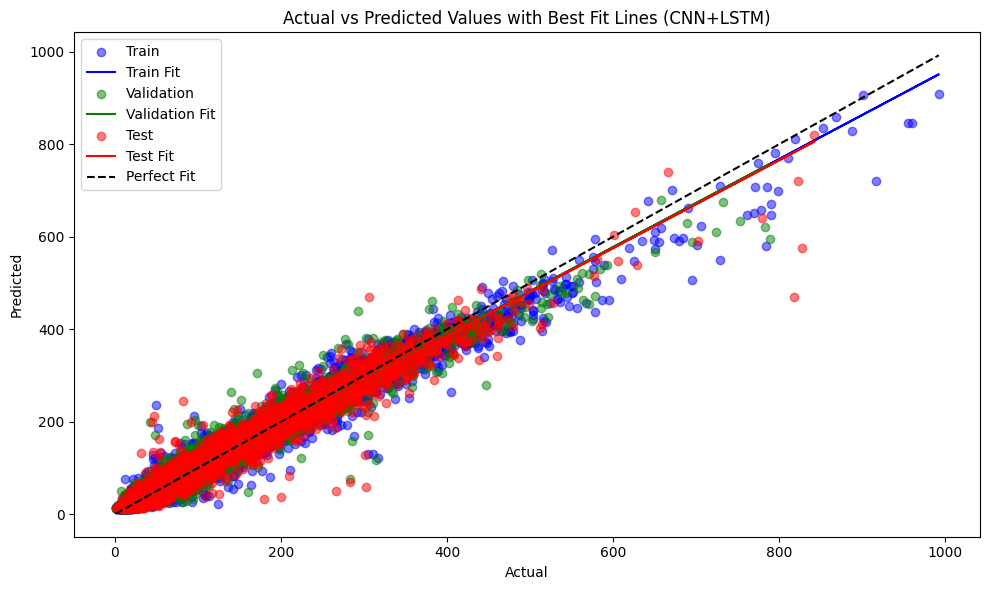

In [12]:
# --- Actual vs Predicted Scatter Plot ---
def plot_actual_vs_pred(y_true, y_pred, title, color):
    coeffs = np.polyfit(y_true, y_pred, 1)
    fit_line = np.poly1d(coeffs)(y_true)
    plt.scatter(y_true, y_pred, alpha=0.5, label=title, color=color)
    plt.plot(y_true, fit_line, color=color, linestyle='-', label=f"{title} Fit")

plt.figure(figsize=(10, 6))
plot_actual_vs_pred(y_train, y_train_pred, 'Train', 'blue')
plot_actual_vs_pred(y_val, y_val_pred, 'Validation', 'green')
plot_actual_vs_pred(y_test, y_test_pred, 'Test', 'red')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', label='Perfect Fit')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Values with Best Fit Lines (CNN+LSTM)")
plt.legend()
plt.tight_layout()
plt.show()


c:\Users\yuvik\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


c:\Users\yuvik\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


c:\Users\yuvik\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step


c:\Users\yuvik\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


c:\Users\yuvik\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


c:\Users\yuvik\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


c:\Users\yuvik\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


c:\Users\yuvik\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


c:\Users\yuvik\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


c:\Users\yuvik\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


c:\Users\yuvik\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


c:\Users\yuvik\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


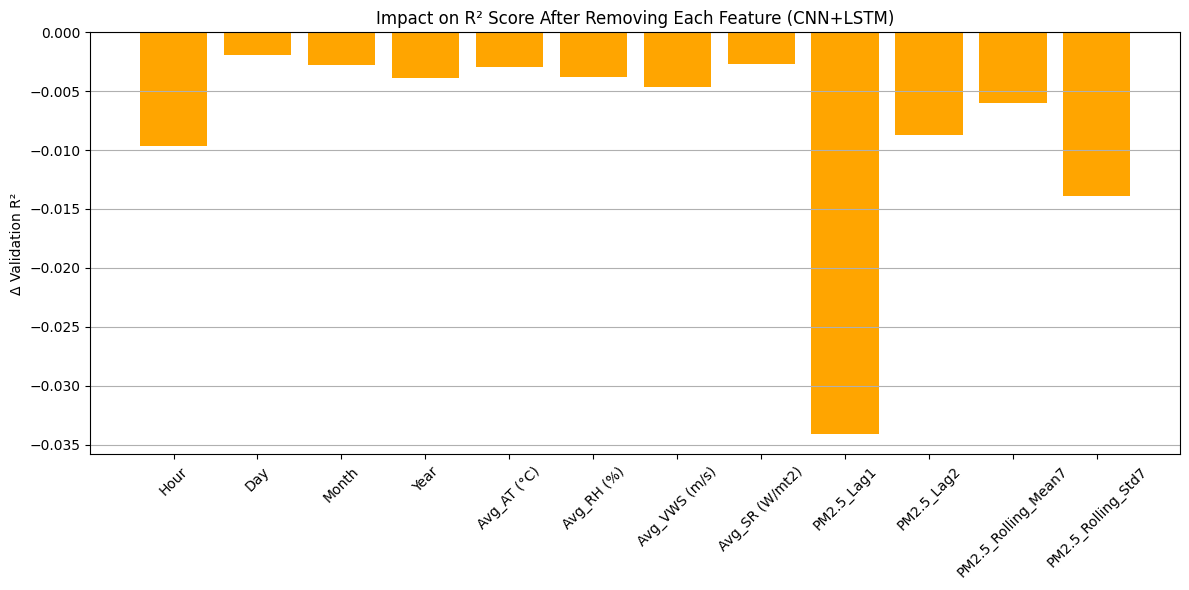

In [13]:
# --- R² Drop per Feature ---
baseline_r2 = r2_score(y_val, y_val_pred)
r2_changes = {}

for feature in features:
    temp_features = X.drop(columns=[feature])
    X_train_f, X_temp_f, y_train_f, y_temp_f = train_test_split(temp_features, y, test_size=0.4, random_state=42)
    X_val_f, X_test_f, y_val_f, y_test_f = train_test_split(X_temp_f, y_temp_f, test_size=0.5, random_state=42)

    scaler = MinMaxScaler()
    X_train_f_norm = scaler.fit_transform(X_train_f)
    X_val_f_norm = scaler.transform(X_val_f)

    X_train_f_cnn = X_train_f_norm.reshape((X_train_f_norm.shape[0], 1, X_train_f_norm.shape[1]))
    X_val_f_cnn = X_val_f_norm.reshape((X_val_f_norm.shape[0], 1, X_val_f_norm.shape[1]))

    model = Sequential([
        Conv1D(64, 1, activation='relu', input_shape=(1, X_train_f_cnn.shape[2])),
        BatchNormalization(),
        Conv1D(128, 1, activation='relu'),
        BatchNormalization(),
        Bidirectional(LSTM(64, return_sequences=True)),
        Bidirectional(LSTM(32)),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_train_f_cnn, y_train_f, validation_data=(X_val_f_cnn, y_val_f),
              epochs=30, batch_size=32, verbose=0, callbacks=[early_stop])

    y_val_pred_f = model.predict(X_val_f_cnn).flatten()
    r2_drop = r2_score(y_val_f, y_val_pred_f) - baseline_r2
    r2_changes[feature] = r2_drop

# Plot R² impact
plt.figure(figsize=(12, 6))
plt.bar(r2_changes.keys(), r2_changes.values(), color='orange')
plt.xticks(rotation=45)
plt.ylabel("Δ Validation R²")
plt.title("Impact on R² Score After Removing Each Feature (CNN+LSTM)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()
